In [1]:
import sys
import os
sys.path.append(os.path.abspath('..'))

import time
from matplotlib import pyplot as plt
import numpy as np
from backends import FockBackend, PermanentBackend, MrMustardBackend, PercevalBackend

### Benchmarking photonic backends
This notebook compares the runtime of various photonic backends by simulating increasing sizes of a symmetric multi-mode interferometer, which couples each input to each output with equal probability.

In [2]:
def generate_bs_wire_list(n_wires):
    """Generate list of beam splitter connections for a symmetric MMI"""
    if n_wires % 2 != 0 or n_wires < 1:
        return None
    bs_wire_list = []
    for wire in range(n_wires):
        if wire % 2 == 0:
            bs_wire_list.append([wire + 1, wire + 2])
    for wire in range(n_wires):
        if wire % 2 == 1 and wire != n_wires - 1:
            bs_wire_list.append([wire + 1, wire + 2])

    if n_wires > 2:
        bs_wire_list.append([1, n_wires])

    return bs_wire_list

In [3]:
backend_list = [FockBackend, PermanentBackend, MrMustardBackend, PercevalBackend]
backend_names = [str(backend.__name__) for backend in backend_list]

n_runs = 10
max_wires = 6

In [4]:
runtimes = np.zeros((len(backend_list), int(max_wires/2)))
n_wires_list = list(range(2, max_wires + 1, 2)) # number of wires in the circuit (2, 4, 6...)

for wire_idx, n_wires in enumerate(n_wires_list):
    # Generate list of beam splitter connections
    bs_wire_list = generate_bs_wire_list(n_wires)

    for idx, backend in enumerate(backend_list):

        # Mr Mustard has trouble with larger circuits
        if backend == MrMustardBackend and n_wires > 4:
            runtimes[idx, wire_idx] = np.nan

        else:
            # Time how long it takes to run the circuit n_runs times
            start_time = time.time()
            for n in range(n_runs):

                # Create the circuit
                circuit = backend(n_wires = n_wires, n_photons = n_wires)
                circuit.set_input_state(tuple([1] + [0]*(n_wires-1)))

                # Add beam splitters
                for bs_wires in bs_wire_list:
                    circuit.add_beamsplitter(wires = bs_wires)

                circuit.run()

            runtimes[idx, wire_idx] = time.time() - start_time

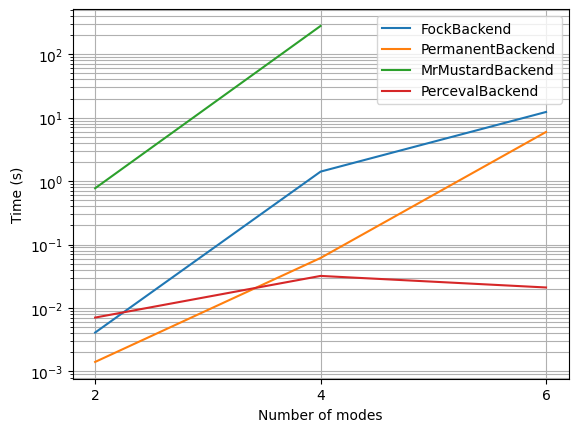

In [5]:
for idx, backend in enumerate(backend_list):
    plt.semilogy(n_wires_list, runtimes[idx, :], label=backend.__name__)
plt.xlabel("Number of modes")
plt.ylabel("Time (s)")
plt.xticks(n_wires_list)
plt.legend()
plt.grid(True, which="both")